<a href="https://colab.research.google.com/github/smomtahe/Deep_Neural_Network/blob/main/LogisticRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
%tensorflow_version 2.x
import tensorflow as tf
import os
import io
import gzip
import math
import random
import operator
import sklearn.model_selection
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as matplot
import matplotlib
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as cPickle
import seaborn as sb
from time import time
from itertools import chain
from subprocess import check_output
from collections import Counter
from PIL import Image
from math import ceil
from scipy.stats import mode
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from pandas.plotting import parallel_coordinates
from scipy import optimize as op
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import os
import glob
import pandas as pd
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Softmax, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Activation, Dropout, Flatten, Dense,Input,Multiply
from keras.optimizers import SGD
from keras.layers import LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
%matplotlib inline
from tensorflow.keras.applications import InceptionV3
from keras.preprocessing.image import load_img, img_to_array
resnet_weights_path='https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h'



In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!unrar x "/content/toronto_face.rar"
# !cp  "/content/drive/MyDrive/data_to_process/toronto_face.rar"  ./

Mounted at /content/drive

UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from /content/toronto_face.rar

Creating    toronto_face                                              OK
Extracting  toronto_face/.DS_Store                                         0%  OK 
Extracting  toronto_face/toronto_face.npz                                 34% 69% 99%  OK 
All OK


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
load tensflow 2.x and tensorboard
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
train data shape (3374, 2304)
test data shape (385, 2304)
validation data shape (419, 2304)


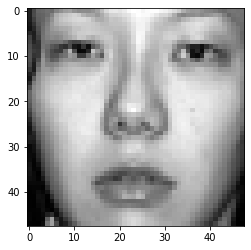

In [ ]:
try:
    %tensorflow_version 2.x
    %load_ext tensorboard
    print('load tensflow 2.x and tensorboard')
except:
    print('not run code')

#load data
def load_data(file_name):
    npzfile = np.load(file_name)

    X_train = npzfile["inputs_train"].T / 255.0
    X_valid = npzfile["inputs_valid"].T / 255.0
    X_test = npzfile["inputs_test"].T / 255.0
    Y_train = npzfile["target_train"].tolist()
    Y_valid = npzfile["target_valid"].tolist()
    Y_test = npzfile["target_test"].tolist()

    num_class = max(Y_train + Y_valid + Y_test) + 1
    Y_train_1hot = np.zeros([num_class, len(Y_train)])
    Y_valid_1hot = np.zeros([num_class, len(Y_valid)])
    Y_test_1hot = np.zeros([num_class, len(Y_test)])

    for ii, xx in enumerate(Y_train):
        Y_train_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(Y_valid):
        Y_valid_1hot[xx, ii] = 1.0

    for ii, xx in enumerate(Y_test):
        Y_test_1hot[xx, ii] = 1.0


    return X_train.T, X_valid.T, X_test.T, Y_train_1hot.T, Y_valid_1hot.T, Y_test_1hot.T

#*Run* the next cell to load the dataset you are going to use.
X_train, X_valid, X_test, Y_train, Y_valid, Y_test = load_data("/content/toronto_face/toronto_face.npz")
from google.colab import drive
drive.mount('/content/drive')
print("train data shape",X_train.shape)
print("test data shape",X_test.shape)
print("validation data shape",X_valid.shape)

###**Now**, take a look at an example of a labelled image in the dataset Feel free to change the value of index below and re-run to see different examples.
ix = 10;
plt.figure(ix)
plt.imshow(X_train[ix].reshape((48, 48)), interpolation='none', cmap='gray')
plt.show()

**Logistic Regression**



In [ ]:
train=(X_train.astype('float32') *0.09/255) +0.01
test=(X_test.astype('float32')*0.09 /255)+0.01

train = (train - np.min(train)) / (np.max(train) - np.min(train))
test = (test - np.min(test)) / (np.max(test) - np.min(test))

trlab=Y_train
tslab=Y_test

dx1=0
dx2=1
def filter(x, y):
      for i in range (len(x)):
        keep = (y == dx1) | (y ==dx2)
        y =  y[keep]
        x =  x[np.where(keep)[i]]
        #y = y == dx1
        return x,y.astype(int)
X, trlab = filter(train,trlab)
test, tslab = filter(test,tslab)

#Number of examples
m = train.shape[0]
#Features
n = train.shape[1]
#Number of classes
k=2
lab = [dx1,dx2]
intercept = np.ones((X.shape[0], 1))
X = np.hstack((intercept, X))
intercept = np.ones((test.shape[0], 1))
test = np.hstack((intercept, test))
#print(test.shape)
trlab[:10]

def error_rate(confusion_matrix):
    a = confusion_matrix
    b = a.sum(axis=1)
    df = []
    for i in range(0,2):
        temp = 1-a[i][i]/b[i]
        df.append(temp)
    df = pd.DataFrame(df)
    df.columns = ['% Error rate']
    return df*100

def sigmoid(z):
  return 1.0 / (1 + np.exp(-z))

#Regularized cost function
def regCostFunction(theta, X, y, L = 0.1, batch_size= 5): # L is the lambda
    h = sigmoid(np.dot(X,theta))  #hypothesis

    J=np.sum(-y * np.log(h) - (1 - y) * np.log(1 - h)) / len(h)
    #print(J)  #print cost
    return J

#Regularized gradient function
def regGradient(X, y, theta, L , iteration, batch_size):
    #print(y[:3]) # actual 0 ,1
    m, n = X.shape
    all_theta=[]
    cost_history = np.zeros(iteration)
    theta=(np.ones((n ,)) * -1)

    max_iters = 100
    for itr in range(iteration):
      cost=0
      for i in range(0,len(X),batch_size):
        h = sigmoid(X.dot(theta))
        tmp = np.copy(theta)
        tmp[0] = 0
        reg = L*tmp/m
        alpha=0.1
        theta = theta*(1-2*alpha*L) -(1/m)*alpha*( X.T.dot((h - y)))
        #print(theta)
        cost+=regCostFunction(theta, X, y, L = 0.1, batch_size= 5) + L* np.sum(np.power(theta,2))
      cost_history[itr]= cost
      all_theta.append(theta)
    plt.plot(cost_history)
    plt.xlabel(" Iteration  ")
    plt.ylabel(" Cost ")
    #plt.show()
    return all_theta, theta, cost_history
#Training
iteration=100
L=0.01
alpha=0.1
temp=[dx1] # first digit
#set the labels in -1 and 1
tmp_y = np.array(trlab == temp, dtype = int)
#print(tmp_y)   #y actual 0,1
all_theta, theta, cost_history= regGradient(X, tmp_y, (np.ones((n + 1,1)) * -1),L , iteration, batch_size = 5)

In [ ]:
#prediction
#compute accuracy
P = sigmoid(test.dot(theta)) #probability for each temp
#print(all_theta.shape) # all weights
#print(P.shape) #hypothesis
probabilities = []
accuratepredicts = 0

for i in range (len(P)):
  if (P[i]>=0.5):
    hypothesis=dx1
  else:
    hypothesis=dx2
  probabilities.append(hypothesis)
  #print(probabilities)

  if (tslab.T[i] == probabilities[i]):
    accuratepredicts+=1
#print(accuratepredicts)

acc=(accuratepredicts/len(P))*100  #accuracy
print("Test Accuracy:", acc , '%')

# X-axis Predicted vs Y-axis Actual Values
matplot.subplots(figsize=(10, 6))
sb.heatmap(confusion_matrix(tslab, probabilities), annot = True, fmt = 'g')
matplot.xlabel("Predicted")
matplot.ylabel("Actual")
matplot.title("Confusion Matrix")
matplot.show()

from sklearn.metrics import precision_score
from sklearn import metrics
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

precision = precision_score(tslab, probabilities, average='weighted')
recall_sensitivity = metrics.recall_score(tslab, probabilities,average='weighted')
f1_positive = metrics.f1_score(tslab, probabilities,average='weighted')
specificity = metrics.recall_score(tslab, probabilities, pos_label=dx1)
print('Precision: %.3f' % precision)
print('Recall (sensitivity): %.3f' % recall_sensitivity)
print('Specificity: %.3f' % specificity)
print('F1_score: %.3f' % f1_positive)